Useful links

1. For the architecture https://towardsdatascience.com/deep-learning-for-specific-information-extraction-from-unstructured-texts-12c5b9dceada
2. https://androidkt.com/multi-label-text-classification-in-tensorflow-keras/
3. https://keras.io/preprocessing/sequence/
4. https://machinelearningmastery.com/develop-word-based-neural-language-models-python-keras/ ( Not really)
5. For deep learning using word embeddings https://stackabuse.com/python-for-nlp-multi-label-text-classification-with-keras/



In [1]:
import spacy
import pandas as pd
from tqdm import tqdm

In [2]:
DATA_DIR = "../../data/processed/"
INPUT_FILE_NAME = 'cleaned_squash3_with_pos_ner.parquet'

In [3]:
df = pd.read_parquet(DATA_DIR + INPUT_FILE_NAME)
df.head()

,speaker,headline,description,duration,tags,transcript,WC,clean_transcript,clean_transcript_string,squash_tags,squash2_tags,squash3_tags,pos_sequence,ner_sequence
0,Al Gore,Averting the climate crisis,With the same humor and humanity he exuded in ...,0:16:17,"cars,alternative energy,culture,politics,scien...","0:14\r\r\rThank you so much, Chris.\rAnd it's ...",2281.0,"[thank, chris, truly, great, honor, opportunit...",thank chris truly great honor opportunity come...,"culture,politics,science,climate change,enviro...","culture,politics,science,global issues,environ...","culture,politics,science,global issues,environ...",VERB PROPN ADV ADJ NOUN NOUN VERB NOUN ADV ADV...,PERSON ORG ORG GPE LOC ORG PRODUCT GPE GPE PER...
1,Amy Smith,Simple designs to save a life,Fumes from indoor cooking fires kill more than...,0:15:06,"MacArthur grant,simplicity,industrial design,a...","0:11\r\r\rIn terms of invention,\rI'd like to ...",2687.0,"[term, invention, like, tell, tale, favorite, ...",term invention like tell tale favorite project...,"invention,engineering,design,global issues","invention,engineering,design,global issues","invention,design,global issues",NOUN NOUN SCONJ VERB PROPN ADJ NOUN VERB NOUN ...,GPE DATE CARDINAL DATE ORG PERSON LOC ORG GPE ...
2,Ashraf Ghani,How to rebuild a broken state,Ashraf Ghani's passionate and powerful 10-minu...,0:18:45,"corruption,poverty,economics,investment,milita...","0:12\r\r\rA public, Dewey long ago observed,\r...",2506.0,"[public, dewey, long, ago, observe, constitute...",public dewey long ago observe constitute discu...,"poverty,economics,culture,politics,policy,glob...","inequality,economics,culture,politics,governme...","inequality,economics,culture,politics,global i...",ADJ PROPN ADV ADV VERB ADJ NOUN NOUN PROPN PRO...,DATE NORP ORDINAL DATE MONEY DATE DATE DATE EV...
3,Burt Rutan,The real future of space exploration,"In this passionate talk, legendary spacecraft ...",0:19:37,"aircraft,flight,industrial design,NASA,rocket ...","0:11\r\r\rI want to start off by saying, Houst...",3092.0,"[want, start, say, houston, problem, enter, se...",want start say houston problem enter second ge...,"invention,engineering,entrepreneur,design,busi...","invention,engineering,entrepreneur,design,busi...","invention,design,business",VERB NOUN VERB PROPN NOUN VERB ADJ NOUN NOUN N...,GPE ORDINAL ORG PERSON DATE DATE DATE TIME PER...
4,Chris Bangle,Great cars are great art,American designer Chris Bangle explains his ph...,0:20:04,"cars,industrial design,transportation,inventio...","0:12\r\r\rWhat I want to talk about is, as bac...",3781.0,"[want, talk, background, idea, car, art, actua...",want talk background idea car art actually mea...,"invention,design,technology,business,art","invention,design,technology,business,art","invention,design,technology,business,art",VERB NOUN NOUN NOUN NOUN NOUN ADV ADJ NOUN NOU...,PERSON PRODUCT ORG ORG PERSON PERSON PERSON OR...


In [4]:
df.iloc[:,:14].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 14 columns):
speaker                    2328 non-null object
headline                   2328 non-null object
description                2328 non-null object
duration                   2328 non-null object
tags                       2328 non-null object
transcript                 2328 non-null object
WC                         2328 non-null float64
clean_transcript           2328 non-null object
clean_transcript_string    2328 non-null object
squash_tags                2328 non-null object
squash2_tags               2328 non-null object
squash3_tags               2328 non-null object
pos_sequence               2328 non-null object
ner_sequence               2328 non-null object
dtypes: float64(1), object(13)
memory usage: 254.8+ KB


In [5]:
def print_full_dataframe(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
def compute_tag_ratio(target_column, df=df):
    tags = df[target_column].str.replace(', ',',').str.lower().str.strip()
    split_tags = tags.str.split(',')
    tag_counts_per_talk = split_tags.apply(len)

    joined_tags = tags.str.cat(sep=',').split(',')
    all_tags = pd.Series(joined_tags)

    tag_counts = all_tags.value_counts().rename_axis(target_column).reset_index(name='counts')
    tag_counts['no_count'] = len(df)-tag_counts['counts']
    tag_counts['ratio'] = tag_counts['counts']/tag_counts['no_count']
    tag_counts['overall_ratio'] = tag_counts['counts']/(tag_counts['no_count'] + tag_counts['counts'])
    return tag_counts

#print(compute_tag_ratio('squash3_tags', df))
squashed_tag_counts = compute_tag_ratio('squash3_tags', df)
print_full_dataframe(squashed_tag_counts)

     squash3_tags  counts  no_count     ratio  overall_ratio
0         culture    1106      1222  0.905074       0.475086
1         science     868      1460  0.594521       0.372852
2      technology     787      1541  0.510707       0.338058
3   global issues     679      1649  0.411765       0.291667
4          design     400      1928  0.207469       0.171821
5        business     329      1999  0.164582       0.141323
6   entertainment     285      2043  0.139501       0.122423
7             art     261      2067  0.126270       0.112113
8          future     218      2110  0.103318       0.093643
9    biodiversity     215      2113  0.101751       0.092354
10      education     206      2122  0.097078       0.088488
11  communication     185      2143  0.086328       0.079467
12       politics     183      2145  0.085315       0.078608
13       humanity     164      2164  0.075786       0.070447
14  collaboration     163      2165  0.075289       0.070017
15           life     15

# 3. Feature Extraction via Deep learning

## 3.1 Create one hot encoding

In [6]:
# from sklearn.preprocessing import MultiLabelBinarizer

# y = []
# for index, row in df.iterrows():
#     y.append(set(row['squash3_tags'].split(',')))
    
# mlb = MultiLabelBinarizer()
# encoded_y = mlb.fit_transform(y)

In [7]:
# print(encoded_y[0])
# print(len(encoded_y[0]))

In [8]:
joined_tags = df['squash3_tags'].str.cat(sep=',').split(',')
all_tags = pd.Series(joined_tags).str.strip().str.lower()
all_tags = list(dict.fromkeys(all_tags))
try:
    all_tags.remove('')
except:
    pass
print(all_tags)
print(len(all_tags))

['culture', 'politics', 'science', 'global issues', 'environment', 'technology', 'invention', 'design', 'inequality', 'economics', 'business', 'art', 'biodiversity', 'music', 'entertainment', 'collaboration', 'education', 'history', 'future', 'communication', 'community', 'activism', 'children', 'brain', 'humanity', 'life']
26


In [9]:
def create_one_hot_encode(df=df):
    complete_transcripts_tags = []
    for rows, value in df.iterrows():
        one_hot_encoding = [0] * 26
        headline = [value['headline']]
        transcript = [value['clean_transcript_string']]
        pos_sequence = [value['pos_sequence']]
        ner_sequence = [value['ner_sequence']]
        indiv_tags = value['squash3_tags'].split(',')
        for tags in indiv_tags:
            if tags == '':
                continue
            index = all_tags.index(tags.lower().lstrip(' '))
            one_hot_encoding[index] = 1
        indiv_transcript_tags = headline + transcript + pos_sequence + ner_sequence + one_hot_encoding
        complete_transcripts_tags.append(indiv_transcript_tags)
    return pd.DataFrame(complete_transcripts_tags, columns=['headline', 'transcript', 'pos_sequence', 'ner_sequence'] + all_tags)

In [10]:
df = create_one_hot_encode()
df

,headline,transcript,pos_sequence,ner_sequence,culture,politics,science,global issues,environment,technology,...,education,history,future,communication,community,activism,children,brain,humanity,life
0,Averting the climate crisis,thank chris truly great honor opportunity come...,VERB PROPN ADV ADJ NOUN NOUN VERB NOUN ADV ADV...,PERSON ORG ORG GPE LOC ORG PRODUCT GPE GPE PER...,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,Simple designs to save a life,term invention like tell tale favorite project...,NOUN NOUN SCONJ VERB PROPN ADJ NOUN VERB NOUN ...,GPE DATE CARDINAL DATE ORG PERSON LOC ORG GPE ...,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,How to rebuild a broken state,public dewey long ago observe constitute discu...,ADJ PROPN ADV ADV VERB ADJ NOUN NOUN PROPN PRO...,DATE NORP ORDINAL DATE MONEY DATE DATE DATE EV...,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The real future of space exploration,want start say houston problem enter second ge...,VERB NOUN VERB PROPN NOUN VERB ADJ NOUN NOUN N...,GPE ORDINAL ORG PERSON DATE DATE DATE TIME PER...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Great cars are great art,want talk background idea car art actually mea...,VERB NOUN NOUN NOUN NOUN NOUN ADV ADJ NOUN NOU...,PERSON PRODUCT ORG ORG PERSON PERSON PERSON OR...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,Why glass towers are bad for city life -- and ...,imagine walk even discover everybody room look...,VERB NOUN ADV VERB PRON NOUN VERB ADV NOUN NOU...,ORG GPE ORG GPE GPE GPE GPE GPE GPE GPE GPE PE...,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2324,What happens in your brain when you pay attent...,pay close attention easy attention pull differ...,VERB ADJ NOUN ADJ NOUN VERB ADJ NOUN NOUN NOUN...,ORDINAL PERSON PRODUCT DATE EVENT,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2325,Why you should define your fears instead of yo...,happy pic take senior college right dance prac...,ADJ PROPN VERB ADJ NOUN ADJ NOUN NOUN ADJ VERB...,DATE PERSON ORG PERSON PERSON GPE PERSON GPE O...,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2326,12 truths I learned from life and writing,sevenyearold grandson sleep hall wake lot morn...,PROPN PROPN PROPN PROPN VERB NOUN NOUN VERB VE...,PERSON PERSON PERSON PERSON PERSON DATE CARDIN...,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [11]:
def get_target_column(target_tag, df=df):
    return df[['headline', 'transcript','pos_sequence', 'ner_sequence', target_tag]]
single_class = get_target_column('culture', df)

In [12]:
# df_x = single_class[['transcript']]
# df_y = df[['technology']]

In [13]:
df_x = single_class[['headline', 'transcript','pos_sequence', 'ner_sequence']]
df_y = list(single_class['culture'])
#print(df_x[0])

## 3.2 Perform train test split

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, train_y, valid_y = train_test_split(df_x, df_y)

In [15]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, Conv1D, MaxPooling1D, concatenate
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras import optimizers
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import numpy as np

Using TensorFlow backend.


## 3.3 Use word embeddings for the main transcript

In [16]:
# Extract train and test transcripts to list 
X_train_transcripts = X_train['transcript'].tolist()
X_test_transcripts = X_test['transcript'].tolist()
# Extract headline - we will use tfidf because headlines are short 
X_train_headline = X_train['headline'].tolist()
X_test_headline = X_test['headline'].tolist()
# Extract POS tags
X_train_pos_seq= X_train['pos_sequence'].tolist()
X_test_pos_seq = X_test['pos_sequence'].tolist()
# Extract NER tags
X_train_ner_seq = X_train['ner_sequence'].tolist()
X_test_ner_seq = X_test['ner_sequence'].tolist()

In [17]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train_transcripts)

X_train_transcripts = tokenizer.texts_to_sequences(X_train_transcripts)
X_test_transcripts = tokenizer.texts_to_sequences(X_test_transcripts)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 500 # since the average length is about there. Too long and the predicions are bad. we assume the intro has the most info

X_train_transcripts = pad_sequences(X_train_transcripts, padding='post', maxlen=maxlen)
X_test_transcripts = pad_sequences(X_test_transcripts, padding='post', maxlen=maxlen)

In [18]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('./glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [19]:
print(X_train_transcripts[1])
print(X_train_transcripts.shape)
print(type(X_train_transcripts))

[ 522 1149  522 4334  563 2710  139 1793  302 1793 1253  562    5   17
    1  161   17    1   33  161   17  899  774  181  124   18 1349   35
  444  444  159  262 1080  481   70 4109   53    6   46  283   58  513
   36 1794    6    3  124  513  197   15   15  190   17   64    1   59
  190  294 3242   42  767   40   88  283  139   34  130  446   12  829
  283 1657   18   22 2738   59  124 1915  283 1915   59  273  604   26
  833    3   15  167 1189  937  335   59  353   22  353  434  348    7
  283  130  229  348 2500  622  280   15   65   65  283   58  513    4
  305   64    1   59  124  106  124    1  448   42   11  438  261  276
  492  261  276   43  527  124 1594  124    1  217   19  367  294 3242
    4  367   48   59  192  112  447  124   48  244 1667  112 1914  124
  229 1038    3   16 2059   87 1279  438  554   10  130  683  492   15
   11   36  522 1636  841   17  522   90  683  492   15    3  284   79
    5   42 1087  372  227 1087  372 2060  276    6  799  830  781 1843
   59 

In [20]:
print(train_y[0])

0


## 3.4 tfidf the headline

In [21]:
# tfidf_vect_pos = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=50)
# tfidf_vect_pos.fit(X_train_headline)

# xtrain_tfidf_headline =  tfidf_vect_pos.transform(X_train_headline)
# xtest_tfidf_headline =  tfidf_vect_pos.transform(X_test_headline)


In [22]:
# print(xtrain_tfidf_headline.shape)
# print(xtest_tfidf_headline.shape)
# print(xtrain_tfidf_headline[0])
# print(type(xtrain_tfidf_headline))

In [23]:
# tfidf_vect_pos = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
# tfidf_vect_pos.fit(df['pos_sequence'])
# tfidf_vect_ner = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
# tfidf_vect_ner.fit(df['ner_sequence'])

# xtrain_tfidf_pos =  tfidf_vect_pos.transform(X_train['pos_sequence'])
# xtest_tfidf_pos =  tfidf_vect_pos.transform(X_test['pos_sequence'])

# xtrain_tfidf_ner =  tfidf_vect_ner.transform(X_train['ner_sequence'])
# xtest_tfidf_ner =  tfidf_vect_ner.transform(X_test['ner_sequence'])

In [24]:
# Try word embeddings on the vector 
tokenizer2 = Tokenizer(num_words=100)
tokenizer2.fit_on_texts(X_train_headline)

X_train_headline = tokenizer.texts_to_sequences(X_train_headline)
X_test_headline = tokenizer.texts_to_sequences(X_test_headline)

vocab_size2 = len(tokenizer2.word_index) + 1

maxlen2 = 100 # since the average length is about there. Too long and the predicions are bad. we assume the intro has the most info

X_train_headline = pad_sequences(X_train_headline, padding='post', maxlen=maxlen2)
X_test_headline = pad_sequences(X_test_headline, padding='post', maxlen=maxlen2)

# Model

In [25]:
from keras.utils import plot_model
# define two sets of inputs
inputA = Input(shape=(maxlen2,))
inputB = Input(shape=(maxlen,))
 
# the first branch operates on the first input which is the headline
embedding_layer_hedline = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(inputA) 
#model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
#model.add(layers.Conv1D(128, 5, activation='relu'))
x = Conv1D(128, 5, activation='relu')(embedding_layer_hedline)
# model.add(layers.GlobalMaxPooling1D())
x = GlobalMaxPooling1D()(x)
x = Dense(10, activation='relu')(x)
X = Dropout(0.2)(x)
x = Dense(4, activation="relu")(x)
# model.add(layers.Dense(10, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))

# x = Dense(50, activation="relu")(inputA)
# x = Dense(4, activation="relu")(x)
x = Model(inputs=inputA, outputs=x)
 
# the second branch opreates on the second input
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(inputB)
y = LSTM(128)(embedding_layer)
y = Dropout(0.2)(y)
y = Dense(4, activation='relu')(y)
y = Model(inputs=inputB, outputs=y)
 
# combine the output of the two branches
combined = concatenate([x.output, y.output])
 
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(2, activation="relu")(combined)
z = Dense(1, activation="sigmoid")(z)
 
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)
print(model.summary())
adam = optimizers.adam(lr=0.0001)
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc'])











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 100)     4268300     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 96, 128)      64128       embedding_1[0][0] 

In [26]:
adam = optimizers.adam(lr=0.001)
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc'])
history = model.fit([X_train_headline, X_train_transcripts], train_y, batch_size=32, epochs=4, verbose=1, validation_split=0.2)



Train on 1396 samples, validate on 350 samples
Epoch 1/4
1396/1396 [==============================] - 153s 110ms/step - loss: 0.6921 - acc: 0.5251 - val_loss: 0.6877 - val_acc: 0.5629
Epoch 2/4
1396/1396 [==============================] - 127s 91ms/step - loss: 0.6456 - acc: 0.6010 - val_loss: 0.7203 - val_acc: 0.5286
Epoch 3/4
1396/1396 [==============================] - 132s 94ms/step - loss: 0.5964 - acc: 0.6676 - val_loss: 0.6866 - val_acc: 0.5629
Epoch 4/4
1396/1396 [==============================] - 131s 94ms/step - loss: 0.5152 - acc: 0.7536 - val_loss: 0.8433 - val_acc: 0.5286


In [27]:
# from keras.utils import plot_model
# # define two sets of inputs
# inputA = Input(shape=(50,))
# inputB = Input(shape=(maxlen,))
 
# # the first branch operates on the first input
# x = Dense(50, activation="relu")(inputA)
# x = Dense(4, activation="relu")(x)
# x = Model(inputs=inputA, outputs=x)
 
# # the second branch opreates on the second input
# embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(inputB)
# y = LSTM(128)(embedding_layer)
# y = Dense(4, activation='sigmoid')(y)
# y = Model(inputs=inputB, outputs=y)
 
# # combine the output of the two branches
# combined = concatenate([x.output, y.output])
 
# # apply a FC layer and then a regression prediction on the
# # combined outputs
# z = Dense(2, activation="relu")(combined)
# z = Dense(1, activation="linear")(z)
 
# # our model will accept the inputs of the two branches and
# # then output a single value
# model = Model(inputs=[x.input, y.input], outputs=z)
# print(model.summary())
# adam = optimizers.adam(lr=0.0001)
# #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc'])

In [28]:
plot_model(model, to_file='model_plot_cnn.png', show_shapes=True, show_layer_names=True)

In [29]:
# adam = optimizers.adam(lr=0.0001)
# #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc'])
# history = model.fit([xtrain_tfidf_headline, X_train_transcripts], train_y, batch_size=32, epochs=4, verbose=1, validation_split=0.2)

In [30]:
# from keras.utils import plot_model
# plot_model(model)

In [31]:
# deep_inputs = Input(shape=(maxlen,))
# embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
# LSTM_Layer_1 = LSTM(128)(embedding_layer)
# dense_layer_1 = Dense(1, activation='sigmoid')(LSTM_Layer_1)
# model = Model(inputs=deep_inputs, outputs=dense_layer_1)

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# history = model.fit(X_train, train_y, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

In [32]:
# model_glove = Sequential()
# model_glove.add(Embedding(vocab_size, 100, input_length=3000, weights=[embedding_matrix], trainable=False))(Input(shape=(maxlen,)))
# model_glove.add(Dropout(0.2))
# model_glove.add(Conv1D(64, 5, activation='relu'))
# model_glove.add(MaxPooling1D(pool_size=4))
# model_glove.add(LSTM(100))
# model_glove.add(Dense(1, activation='sigmoid'))
# model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# ## Fit train data
# model_glove.fit(X_train, np.array(train_y), validation_split=0.2, epochs = 3)

In [33]:
predictions = model.predict([X_test_headline, X_test_transcripts])

In [34]:
print(predictions)

[[0.0506216 ]
 [0.7015069 ]
 [0.771372  ]
 [0.7046806 ]
 [0.3308062 ]
 [0.54171705]
 [0.64751625]
 [0.17043173]
 [0.53182375]
 [0.15405098]
 [0.01686966]
 [0.6094669 ]
 [0.23457596]
 [0.7087351 ]
 [0.33083844]
 [0.53438133]
 [0.43729925]
 [0.30675387]
 [0.06718248]
 [0.19494626]
 [0.33276278]
 [0.7176246 ]
 [0.82287955]
 [0.56874925]
 [0.48245707]
 [0.7068858 ]
 [0.72965884]
 [0.05217862]
 [0.25651515]
 [0.15907162]
 [0.2775736 ]
 [0.7101451 ]
 [0.2170488 ]
 [0.2410909 ]
 [0.20428258]
 [0.46574804]
 [0.41968566]
 [0.50015247]
 [0.26167285]
 [0.4912542 ]
 [0.3446594 ]
 [0.08268791]
 [0.5118027 ]
 [0.11423931]
 [0.06188875]
 [0.5755898 ]
 [0.70481646]
 [0.38806266]
 [0.03264368]
 [0.25701624]
 [0.6536801 ]
 [0.27295253]
 [0.14607769]
 [0.7601503 ]
 [0.6367817 ]
 [0.4593596 ]
 [0.16319877]
 [0.12724057]
 [0.8519433 ]
 [0.16641438]
 [0.02178499]
 [0.25872493]
 [0.48524693]
 [0.5589116 ]
 [0.6263304 ]
 [0.4012768 ]
 [0.46574804]
 [0.48110595]
 [0.10224521]
 [0.4142361 ]
 [0.24237874]
 [0.28

In [56]:
def get_tag(threshold, predictions=predictions):
    return [[1 if j > threshold else 0 for j in i.tolist()] for i in predictions]

def get_tag_flat(threshold, predictions=predictions):
    return [1 if j > threshold else 0 for i in predictions for j in i]
predictions_flushed = get_tag(0.4)


In [36]:
def compute_tp_tn_fp_fn(y_test, y_pred, classes):
    '''
    Return:
    pre_score = {
        'tag_1': {
            'index': ,
            'tp': ,
            'tn': ,
            'fp': ,
            'fn': 
        }
    }
    '''
    # Create dictionary of tags 
    pre_score = {}
    for index_tag, tag in enumerate(classes):
        pre_score[tag] = {
            'index':index_tag,
            'tp': 0,
            'tn': 0,
            'fp': 0,
            'fn': 0
        }
    for transcript_index, transcript_value in enumerate(y_test):
        if transcript_value == y_pred[transcript_index][0] and transcript_value == 1:
            pre_score[classes[0]]['tp'] += 1
        elif transcript_value == y_pred[transcript_index][0] and transcript_value == 0:
            pre_score[classes[0]]['tn'] += 1
        elif transcript_value != y_pred[transcript_index][0] and transcript_value == 1:
            pre_score[classes[0]]['fn'] += 1
        elif transcript_value != y_pred[transcript_index][0] and transcript_value == 0:
            pre_score[classes[0]]['fp'] += 1
    return pre_score
scores_preprocess = compute_tp_tn_fp_fn(valid_y, predictions_flushed, ['culture'])

In [37]:
def compute_precision_recall_f1(preprocessed_scores):
    for key, value in preprocessed_scores.items():
        try:
            precision = value['tp']/(value['tp']+value['fp'])
        except:
            print('precision issue: {}'.format(key))
            precision = 0.0
        try:
            recall = value['tp']/(value['tp']+value['fn'])
        except:
            print('recall issue: {}'.format(key))
            recall = 0.0
        try:
            f1 = (2 * precision * recall)/(precision + recall)
        except:
            print('f1 issue: {}'.format(key))
            f1=0.0
        preprocessed_scores[key]['precision'] = round(precision,2)
        preprocessed_scores[key]['recall'] = round(recall,2)
        preprocessed_scores[key]['f1'] = round(f1,2)
    return preprocessed_scores
final_scores = compute_precision_recall_f1(scores_preprocess)
print(final_scores)

{'culture': {'index': 0, 'tp': 74, 'tn': 242, 'fp': 58, 'fn': 208, 'precision': 0.56, 'recall': 0.26, 'f1': 0.36}}


In [38]:
def print_full_dataframe(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [39]:
def format_scores_df(tag_classes, final_scores=final_scores):
    precision = []
    recall = []
    f1 = []
    accuracy = []
    for index, value in enumerate(tag_classes):
        precision.append(final_scores[value]['precision'])
        recall.append(final_scores[value]['recall'])
        f1.append(final_scores[value]['f1'])
        accuracy.append((final_scores[value]['tp'] + final_scores[value]['tn'])/(final_scores[value]['tp'] + final_scores[value]['tn'] + final_scores[value]['fp'] + final_scores[value]['fn']))
    df_result = pd.DataFrame(list(zip(tag_classes, precision, recall, f1, accuracy)), 
               columns =['class', 'precision', 'recall', 'f1', 'accuracy']) 
    return df_result
df_results = format_scores_df(['culture'], final_scores)
print_full_dataframe(df_results)

     class  precision  recall    f1  accuracy
0  culture       0.56    0.26  0.36  0.542955


In [47]:
for i in range(30, 44):
    i = i/100
    print(i)
    predictions_flushed = get_tag(i)
    scores_preprocess = compute_tp_tn_fp_fn(valid_y, predictions_flushed, ['culture'])
    final_scores = compute_precision_recall_f1(scores_preprocess)
    print(final_scores)
    df_results = format_scores_df(['culture'], final_scores)
    print(df_results)
    print('\n')

0.3
{'culture': {'index': 0, 'tp': 190, 'tn': 128, 'fp': 172, 'fn': 92, 'precision': 0.52, 'recall': 0.67, 'f1': 0.59}}
     class  precision  recall    f1  accuracy
0  culture       0.52    0.67  0.59  0.546392


0.31
{'culture': {'index': 0, 'tp': 187, 'tn': 133, 'fp': 167, 'fn': 95, 'precision': 0.53, 'recall': 0.66, 'f1': 0.59}}
     class  precision  recall    f1  accuracy
0  culture       0.53    0.66  0.59  0.549828


0.32
{'culture': {'index': 0, 'tp': 185, 'tn': 138, 'fp': 162, 'fn': 97, 'precision': 0.53, 'recall': 0.66, 'f1': 0.59}}
     class  precision  recall    f1  accuracy
0  culture       0.53    0.66  0.59  0.554983


0.33
{'culture': {'index': 0, 'tp': 183, 'tn': 141, 'fp': 159, 'fn': 99, 'precision': 0.54, 'recall': 0.65, 'f1': 0.59}}
     class  precision  recall    f1  accuracy
0  culture       0.54    0.65  0.59  0.556701


0.34
{'culture': {'index': 0, 'tp': 180, 'tn': 149, 'fp': 151, 'fn': 102, 'precision': 0.54, 'recall': 0.64, 'f1': 0.59}}
     class  precisi

In [49]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
def evaluate_on_training_set(y_test, y_pred):
  # Calculate AUC
  print("AUC is: ", roc_auc_score(y_test, y_pred))
  # print out recall and precision
  print(classification_report(y_test, y_pred))
  # print out confusion matrix
  print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
  # # calculate points for ROC curve
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  # Plot ROC curve
  plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred)) 
  plt.plot([0, 1], [0, 1], 'k--') # random predictions curve
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate or (1 - Specifity)')
  plt.ylabel('True Positive Rate or (Sensitivity)')
  plt.title('Receiver Operating Characteristic')

AUC is:  0.5823404255319149
              precision    recall  f1-score   support

           0       0.60      0.59      0.59       300
           1       0.57      0.58      0.57       282

    accuracy                           0.58       582
   macro avg       0.58      0.58      0.58       582
weighted avg       0.58      0.58      0.58       582

Confusion Matrix: 
 [[176 124]
 [119 163]]


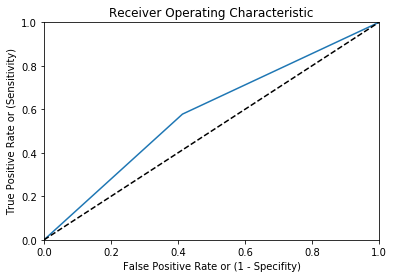

In [57]:
evaluate_on_training_set(valid_y, get_tag_flat(0.4))
#print(valid_y)